# Basic Classifiser for Specific AV

Create a basic classifier for specific vendors, meaning it trains and validates the samples based on a single vendor.

In [1]:
import pandas as pd
import numpy as np
import lib.data_loading as jcfg_data_loading
import lib.helpers as jcfg_helpers
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


test_size = 0.50

# Use the original samples to remove all but the last submission of duplicated samples
samples = pd.read_csv('data/mined_data/pe32_samples.csv')
samples = jcfg_data_loading.set_pd_datetime_index(samples)
samples.drop_duplicates(subset='md5', inplace=True, keep='last')

## Microsoft Classifier

**Ignoring temporal consistency**, train and test a classifier for microsoft only samples

In [2]:
# Load the needed CSVs
static_imports = pd.read_csv('data/mined_data/pe32_static_imports.csv', dtype=str)
static_imports = static_imports.set_index('link')

microsoft_samples = pd.read_csv('data/mined_data/microsoft_classification.csv', dtype=str)
microsoft_samples = microsoft_samples.set_index('link')

# Join the microsoft samples with the imports
dataset = microsoft_samples.join(static_imports).dropna(subset=['imports'])
dataset.drop(['info', 'variant', 'family', 'platform'], axis=1, inplace=True)
# Remove dups
dataset = dataset[dataset.index.isin(samples.link)]

dataset.type.fillna(value=0, inplace=True)


# Filter types of malware
dataset = dataset[(dataset.type == 'worm') | (dataset.type == 0)]


dataset.type = dataset.type.replace(to_replace=None, value=1, regex=r'.+').astype(int)
dataset.rename(columns={'type': 'malware'}, inplace=True)

print('Malware in dataset: {}'.format(len(dataset[dataset.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset[dataset.malware == 0])))

Malware in dataset: 10062
Goodware in dataset: 154556


In [3]:
# How imports vary on malware/goodware
microsoft_malware = dataset[dataset.malware == 1]
microsoft_goodware = dataset[dataset.malware == 0]

mcm_count = microsoft_malware.imports.apply(lambda x: len(x.split(';')))
mcg_count = microsoft_goodware.imports.apply(lambda x: len(x.split(';')))

print('Statistics on malware imports:')
display(mcm_count.describe())
print('\nStatistics on goodware imports:')
display(mcg_count.describe())

Statistics on malware imports:


count    10062.000000
mean        51.105645
std         88.978446
min          1.000000
25%          7.000000
50%         13.000000
75%         68.000000
max       1112.000000
Name: imports, dtype: float64


Statistics on goodware imports:


count    154556.000000
mean        124.116689
std         176.287262
min           1.000000
25%          19.000000
50%          83.000000
75%         154.000000
max       13325.000000
Name: imports, dtype: float64

CC:	0.9767
DR:	0.6901
FP:	0.0975
FN:	0.0197

Malware stats:


count    4979.000000
mean        0.686383
std         0.361997
min         0.000000
25%         0.400000
50%         0.900000
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    77330.000000
mean         0.975583
std          0.078723
min          0.000000
25%          0.988950
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

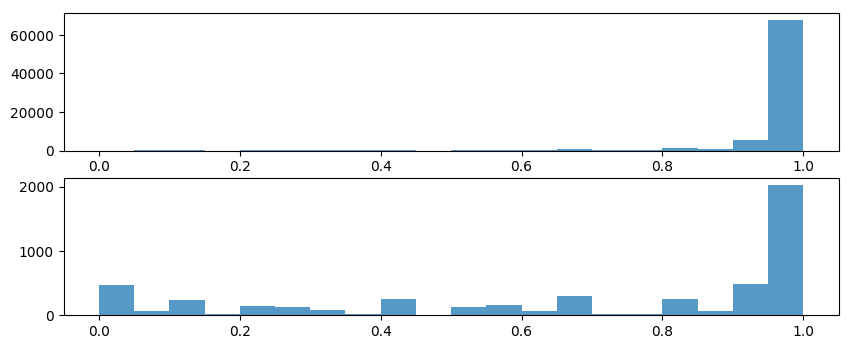

CPU times: user 1min 42s, sys: 863 ms, total: 1min 43s
Wall time: 1min 42s


In [4]:
%%time
# Raw LR, use all imports, dataset balanced as is (more goodware than malware)
# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 10062
Goodware in dataset: 10062
CC:	0.8886
DR:	0.8629
FP:	0.0918
FN:	0.1289

Malware stats:


count    4997.000000
mean        0.847612
std         0.251943
min         0.000000
25%         0.800000
50%         0.993874
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    5065.000000
mean        0.827012
std         0.215734
min         0.000000
25%         0.800000
50%         0.900000
75%         1.000000
max         1.000000
dtype: float64

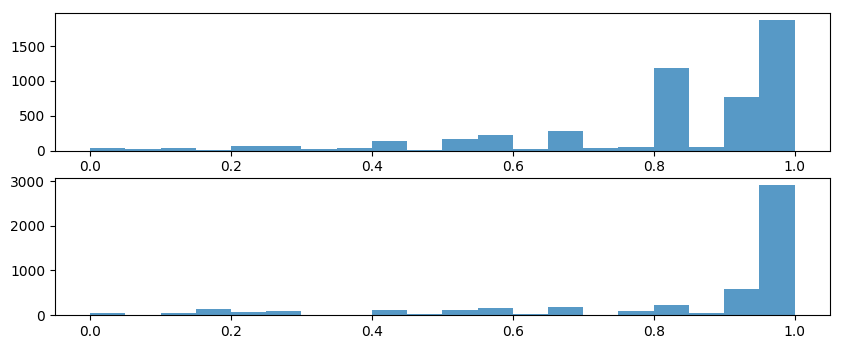

CPU times: user 5.38 s, sys: 413 ms, total: 5.79 s
Wall time: 5.33 s


In [5]:
%%time
# Use all imports, but balance the datasets
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
goodware = dataset[dataset.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset2 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset2[dataset2.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset2[dataset2.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset2, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 10062
Goodware in dataset: 5031
CC:	0.8841
DR:	0.9000
FP:	0.0779
FN:	0.1845

Malware stats:


count    4972.000000
mean        0.881403
std         0.216145
min         0.000000
25%         0.900000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    2575.000000
mean        0.748087
std         0.255620
min         0.000000
25%         0.600000
50%         0.800000
75%         1.000000
max         1.000000
dtype: float64

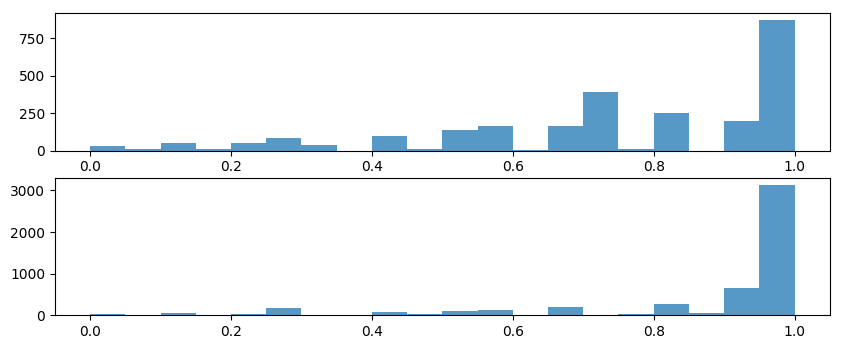

CPU times: user 2.66 s, sys: 300 ms, total: 2.96 s
Wall time: 2.59 s


In [6]:
%%time
# Use all imports, but use more malware for training (more goodware version is default)
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset[dataset.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset3 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset3[dataset3.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset3[dataset3.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset3, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 116125
CC:	0.9723
DR:	0.7029
FP:	0.0919
FN:	0.0237

Malware stats:


count    4723.000000
mean        0.704506
std         0.350100
min         0.000000
25%         0.392713
50%         0.894228
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    58057.000000
mean         0.974117
std          0.084474
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

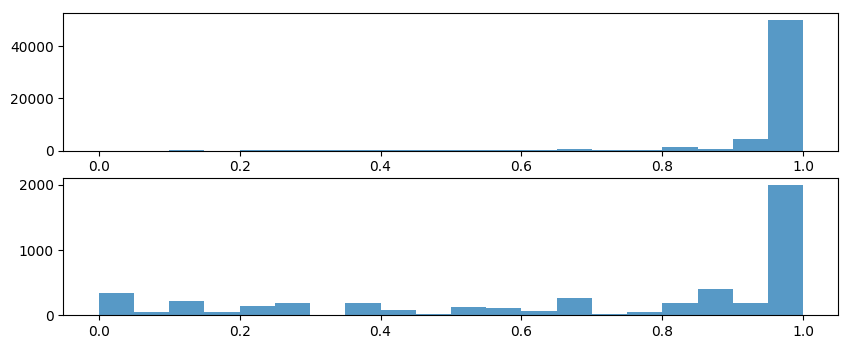

CPU times: user 28 s, sys: 443 ms, total: 28.4 s
Wall time: 28 s


In [7]:
%%time
# Use between 2 and 300 imports (+/- mean + std for goodware), without balancing
# Filter samples by the number of imports
dataset4 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]

print('Malware in dataset: {}'.format(len(dataset4[dataset4.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset4[dataset4.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset4, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 9434
CC:	0.9023
DR:	0.8820
FP:	0.0806
FN:	0.1135

Malware stats:


count    4720.000000
mean        0.869301
std         0.233108
min         0.000000
25%         0.879287
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    4714.000000
mean        0.844565
std         0.224272
min         0.000000
25%         0.780000
50%         0.961259
75%         1.000000
max         1.000000
dtype: float64

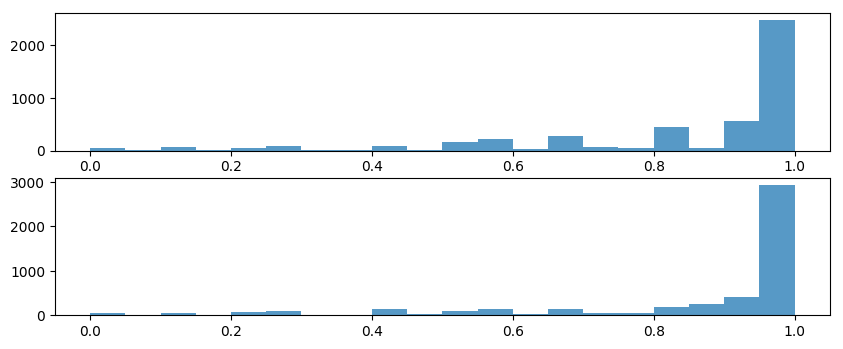

CPU times: user 4.58 s, sys: 327 ms, total: 4.91 s
Wall time: 4.53 s


In [8]:
%%time
# Use between 2 and 300 imports, balanced dataset
dataset5 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset5[dataset5.malware == 1])
goodware_count = len(dataset5[dataset5.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset5[dataset5.malware == 1].sample(n=limiting)
goodware = dataset5[dataset5.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset5 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset5[dataset5.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset5[dataset5.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset5, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 4717
CC:	0.8956
DR:	0.9209
FP:	0.0766
FN:	0.1608

Malware stats:


count    4751.000000
mean        0.905833
std         0.196043
min         0.000000
25%         0.900000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Goodware stats:


count    2325.000000
mean        0.770742
std         0.270582
min         0.000000
25%         0.600000
50%         0.900000
75%         1.000000
max         1.000000
dtype: float64

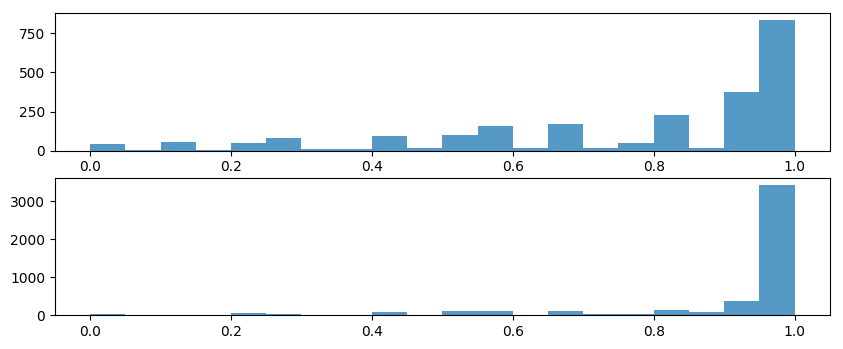

CPU times: user 3.54 s, sys: 333 ms, total: 3.87 s
Wall time: 3.49 s


In [9]:
%%time
# Use up to 300 imports, but with more malware than goodware
dataset6 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset6[dataset6.malware == 1])
goodware_count = len(dataset6[dataset6.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset6[dataset6.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset6[dataset6.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset6 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset6[dataset6.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset6[dataset6.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset6, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()